In [1]:
import pandas as pd
import numpy as np
import librosa
import soundfile

import utils

## Extract feature

In [2]:
def compute_spectrogram_feature(samples, sample_rate, stride_ms=10.0,
                                window_ms=20.0, max_freq=None, eps=1e-14):
    """Compute the spectrograms for the input samples(waveforms).
    the code is from tensorflow research
    """
    if max_freq is None:
        max_freq = sample_rate / 2
    if max_freq > sample_rate / 2:
        raise ValueError("max_freq must not be greater than half of sample rate.")

    if stride_ms > window_ms:
        raise ValueError("Stride size must not be greater than window size.")

    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(
      samples, shape=nshape, strides=nstrides)
    assert np.all(
      windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]
    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2
    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale
    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])

    # Compute spectrogram feature
    ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = np.log(fft[:ind, :] + eps)
    return np.transpose(specgram, (1, 0))

In [43]:
path = '../data/toy_raw/174/168635/174-168635-0000.flac'

au, sr = soundfile.read(path)
sr

16000

In [22]:
feature = compute_spectrogram_feature(au, 16000, 10.0, 20.0)
feature.shape

(452, 161)

In [41]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

feat_pre = pad_sequences(feature.T, maxlen= 2000, padding = 'post').T

In [42]:
feat_pre.shape

(2000, 161)

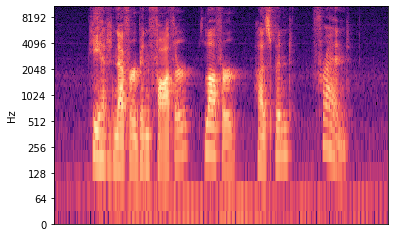

In [24]:
import librosa.display

librosa.display.specshow(feature.T, y_axis='log')

In [5]:
feat_mfcc = utils.extract_features(path)
feat_mfcc.shape

(40, 196)

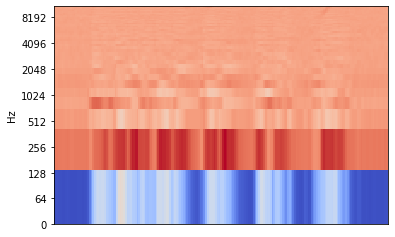

In [21]:
import librosa.display

librosa.display.specshow(feat_mfcc, y_axis='log')

In [18]:
# audio, sample_rate = librosa.load(file_path)
mfccs = librosa.feature.mfcc(y=au, sr=sr,  n_mfcc=40 , hop_length=64, htk=True)
mfccs.shape

(40, 1133)

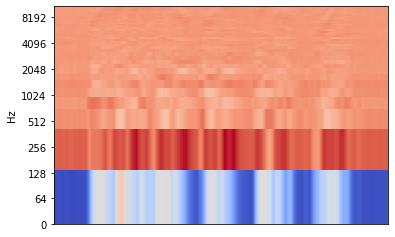

In [20]:
import librosa.display

librosa.display.specshow(mfccs, y_axis='log')

HE HAD NEVER BEEN FATHER LOVER HUSBAND FRIEND


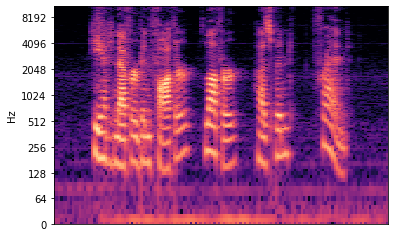

In [37]:
D = np.abs(librosa.stft(au, hop_length=512, ))

librosa.display.specshow(librosa.amplitude_to_db(D,ref=np.max), y_axis='log')

print('HE HAD NEVER BEEN FATHER LOVER HUSBAND FRIEND')

In [36]:
feat_2 = librosa.amplitude_to_db(D,ref=np.max)
feat_2.shape

(1025, 142)

## Read metadata

In [51]:
meta = pd.read_csv('../data/dev-clean-meta/metadata.csv')
meta.head()

,index,filepath,label,label_length,spec_length


In [52]:
meta.spec_length.plot(kind='hist')

TypeError: no numeric data to plot

In [50]:
meta.spec_length.value_counts(bins= 10)

(463.1, 774.2]      87
(148.888, 463.1]    87
(774.2, 1085.3]     73
(1085.3, 1396.4]    22
(1396.4, 1707.5]    19
(1707.5, 2018.6]     9
(2329.7, 2640.8]     3
(2951.9, 3263.0]     2
(2640.8, 2951.9]     2
(2018.6, 2329.7]     2
Name: spec_length, dtype: int64